# Segmentation Task: Med-NCA
As a reminder, Growing NCA, introduced by Mordvintsev et al. in 2020 focus on self-organizing structures and learning growth rules via gradient descent in order to grow a pattern from a single seed. In contrast, Med-NCA is designed to use those base principles for medical image segmentation. It also uses a two-stage approach, combining global and local refinement in order to deliver effective segmentation while still keeping the model lightweight. 

Using NCAs for medical image segmentation proves to be beneficial for multiple reasons:

**Robustness**: The structure makes them inherently robust to small pertubations.

**Local processing**: Information is processed locally but it can learn global patterns through intercellular communication.

In this notebook we attempt to implement [MED-NCA](https://arxiv.org/pdf/2302.03473), which is a two-stage approach to segment medical images, from data preprocessing up to training and evaluation.

## Implementation Overview
Our simplified version of Med-NCA consists of:
1. **NCA Architecture**: Defining the architecture of the NCA2D model
2. **Data Preparation**: Loading and preprocessing 3D medical volumes into 2D slices
3. **Loss Functions**: Definition of the loss functions used
4. **Training Loop**: Training a two-stage NCA pipeline
5. **Evaluation & Visualization**: Evaluation and visualization tools

Note: This notebook assumes you have NIfTI ('.nii.gz') volumes and labels! More details in section 2 **Data Preparation**.
Let's explore each component in detail!

## 0. Imports
We start by importing all necessary libraries for data preparation, model definition and training.

In [ ]:
# imports:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


## 1. NCA Architecture
This class implements a 2D NCA which represents the core of this implementation. It uses depthwise convolution for local perception, as well as stochastic updates which are controlled by `fire_rate`.



In [ ]:
class NCA2D(nn.Module):
    def __init__(self, c=16, h=64, k=1, fire_rate=0.5):
        """NCA for 2D image processing

        Args:
            c: Number of channels
            h: Hidden layer size
            k: Kernel size 
            fire_rate: Probability of cell updates
        """
        super().__init__()
        self.c = c
        self.k = k
        self.fire_rate = fire_rate

        # Depthwise convolution 
        self.perception = nn.Conv2d(c, c, kernel_size=k, padding=k//2, groups= c)

        # Neural network for computing state updates
        self.fc1 = nn.Conv2d(2 * c, h, kernel_size=1)
        self.bn = nn.BatchNorm2d(h, track_running_stats=False)
        self.fc2 = nn.Conv2d(h, c-1, kernel_size=1)

    def forward(self, x):
        """
        Args:
            x: Current cell states (B, C, H, W)    
        """
        B, C, H, W = x.shape

        # Perceive local neighborhood
        px = self.perception(x)

        # Concatenate perception and current state
        v = torch.cat([px, x], dim=1)

        # Pass through the neural network
        out = self.fc1(v)
        out = self.bn(out)
        out = F.relu(out)
        out = self.fc2(out)
       
        # Generate random mask in order to apply stochastic updates based on fire_rate
        update_mask = (torch.rand(B, 1, H, W, device=x.device) <= self.fire_rate).float()
        out = out * update_mask
    

        # Zero-pad first channel to preserve original image
        out= torch.cat([torch.zeros_like(out[:, :1]), out], dim=1)

        return x + out



## 2. Data Preparation
### 2.1 Data Preprocessing
If you don't already have a dataset, it can be found here: [Medical Segmentation Decathlon](http://medicaldecathlon.com/)
For reference, we use the prostate dataset.
In order for our NCA to process the data, we need to process the medical images (NIfTI format) into 2D slices. This is done by:
- Loading the .nii.gz files
- Normalizing intensities
- Extracting the slices along an axis
- Saving the slices as numpy arrays or PNGs

In [ ]:
def normalize(img):
    """Normalizes a numpy image array to [0,1]

    Args:
        img: Image array
    """
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

def save_slice(slice_array, path, as_png=True):
    """Saves the slice either as a PNG or numpy file

    Args:
        slice_array: Array to save
        path: Path the slices should be saved to
        as_png: Set whether to save as PNG or not
    """
    if as_png:
        im = Image.fromarray((slice_array * 255).astype(np.uint8))
        im.save(path)
    else:
        np.save(path, slice_array)

def extract_slices(image_dir, label_dir, out_img_dir, out_lbl_dir, axis=0, as_png=False):
    """
    Args:
        image_dir: Directory with 3D images (.nii.gz)
        label_dir: Directory with corresponding labels (.nii.gz)
        out_img_dir: Directory to save 2D image slices
        out_lbl_dir: Directory to save corresponding labels
        axis: Axis along which to slice (0=sagittal, 1=coronal, 2=axial)
        as_png: Set whether to save as PNG or not
    """
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".nii.gz")])


    for f in tqdm(image_files, desc="Processing volumes"):
        img_path = os.path.join(image_dir, f)
        lbl_path = os.path.join(label_dir, f)

        if not os.path.exists(lbl_path):
            continue

        # Load 3D volumes
        img = nib.load(img_path).get_fdata()
        lbl = nib.load(lbl_path).get_fdata().astype(np.uint8)
        lbl = (lbl > 0).astype(np.uint8)

        # Remove 4th dimension if present
        if img.ndim == 4:
            img = img[..., 0]
        if lbl.ndim == 4:
            lbl = lbl[..., 0] 

        img = normalize(img)  

        if img.shape != lbl.shape:
            print(f"Image and Label mismatch: {img.shape} vs {lbl.shape}")
            continue

        # Move axis to first dimension
        img = np.moveaxis(img, axis, 0)
        lbl = np.moveaxis(lbl, axis, 0)

        # Process slices
        for i in range(img.shape[0]):
            img_slice = img[i]
            lbl_slice = lbl[i]
            
            if img_slice.shape != (320,320):
                print(f"Invalid slice shape: slice {i} of {f} shape: {img_slice.shape}")
                continue
            
            # Ensure consistent naming
            name = f.replace(".nii.gz", f"_slice_{i:03d}")
            save_slice(img_slice, os.path.join(out_img_dir, name + (".png" if as_png else ".npy")), as_png)
            save_slice(lbl_slice, os.path.join(out_lbl_dir, name + (".png" if as_png else ".npy")), as_png)

if __name__ == "__main__":
    extract_slices(
        image_dir="INSERT/path/to/images(imagesTr)",        
        label_dir="INSERT/path/to/labels(imagesTr)",        
        out_img_dir="INSERT/path/to/output/images",  
        out_lbl_dir="/INSERT/path/to/output/labels",  
        axis=2, #axial
        as_png=False
    )

### 2.2 Dataloader
Now we define a class that handles the preprocessed slices.

In [ ]:
class SliceDataset(Dataset):
    """Pytorch Dataset for loading preprocessed 2D slices"""
    def __init__(self, image_dir, label_dir):
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".npy")])
        self.image_dir = image_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        img = np.load(os.path.join(self.image_dir, fname))
        lbl = np.load(os.path.join(self.label_dir, fname))
        
        assert img.shape == lbl.shape, f"Shape mismatch in {fname}: {img.shape} vs {lbl.shape}"
        assert img.shape == (320, 320), f"Unexpected slice size in {fname}: {img.shape}"

        img = torch.from_numpy(img).unsqueeze(0).float()
        lbl = torch.from_numpy(lbl).unsqueeze(0).float()

        return img, lbl

## 3. Loss Functions
Following the implementation of the original Med-NCA, we also use a combination of Dice and BCE loss.

In [ ]:
def dice_loss(pred, target, smooth=1e-5):
    """Dice loss for segmentation"""
    pred = torch.sigmoid(pred)
    pred = torch.flatten(pred)
    target = torch.flatten(target)
    intersect = (pred * target).sum()
    dice = (2 * intersect + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

def dice_score(pred, target, smooth=1e-5):
    """Dice coefficient metric"""
    pred = torch.sigmoid(pred)
    pred = torch.flatten(pred > 0.5).float()
    target = torch.flatten(target)
    intersect = (pred * target).sum()
    score = (2 * intersect + smooth) / (pred.sum() + target.sum() + smooth)
    return score

def bce_loss(pred, target):
    """Binary cross-entropy loss"""
    return F.binary_cross_entropy_with_logits(pred, target)

## 4. Training Loop
The training pipeline consists of two NCA models (coarse and fine scale), which in each step:
- Downsamples the image
- Runs the first NCA (coarse) for a fixed number of steps then upsamples
- Runs the second NCA (fine) for refinement
- Computes the loss

The image below shows the training pipeline of the Med-NCA.

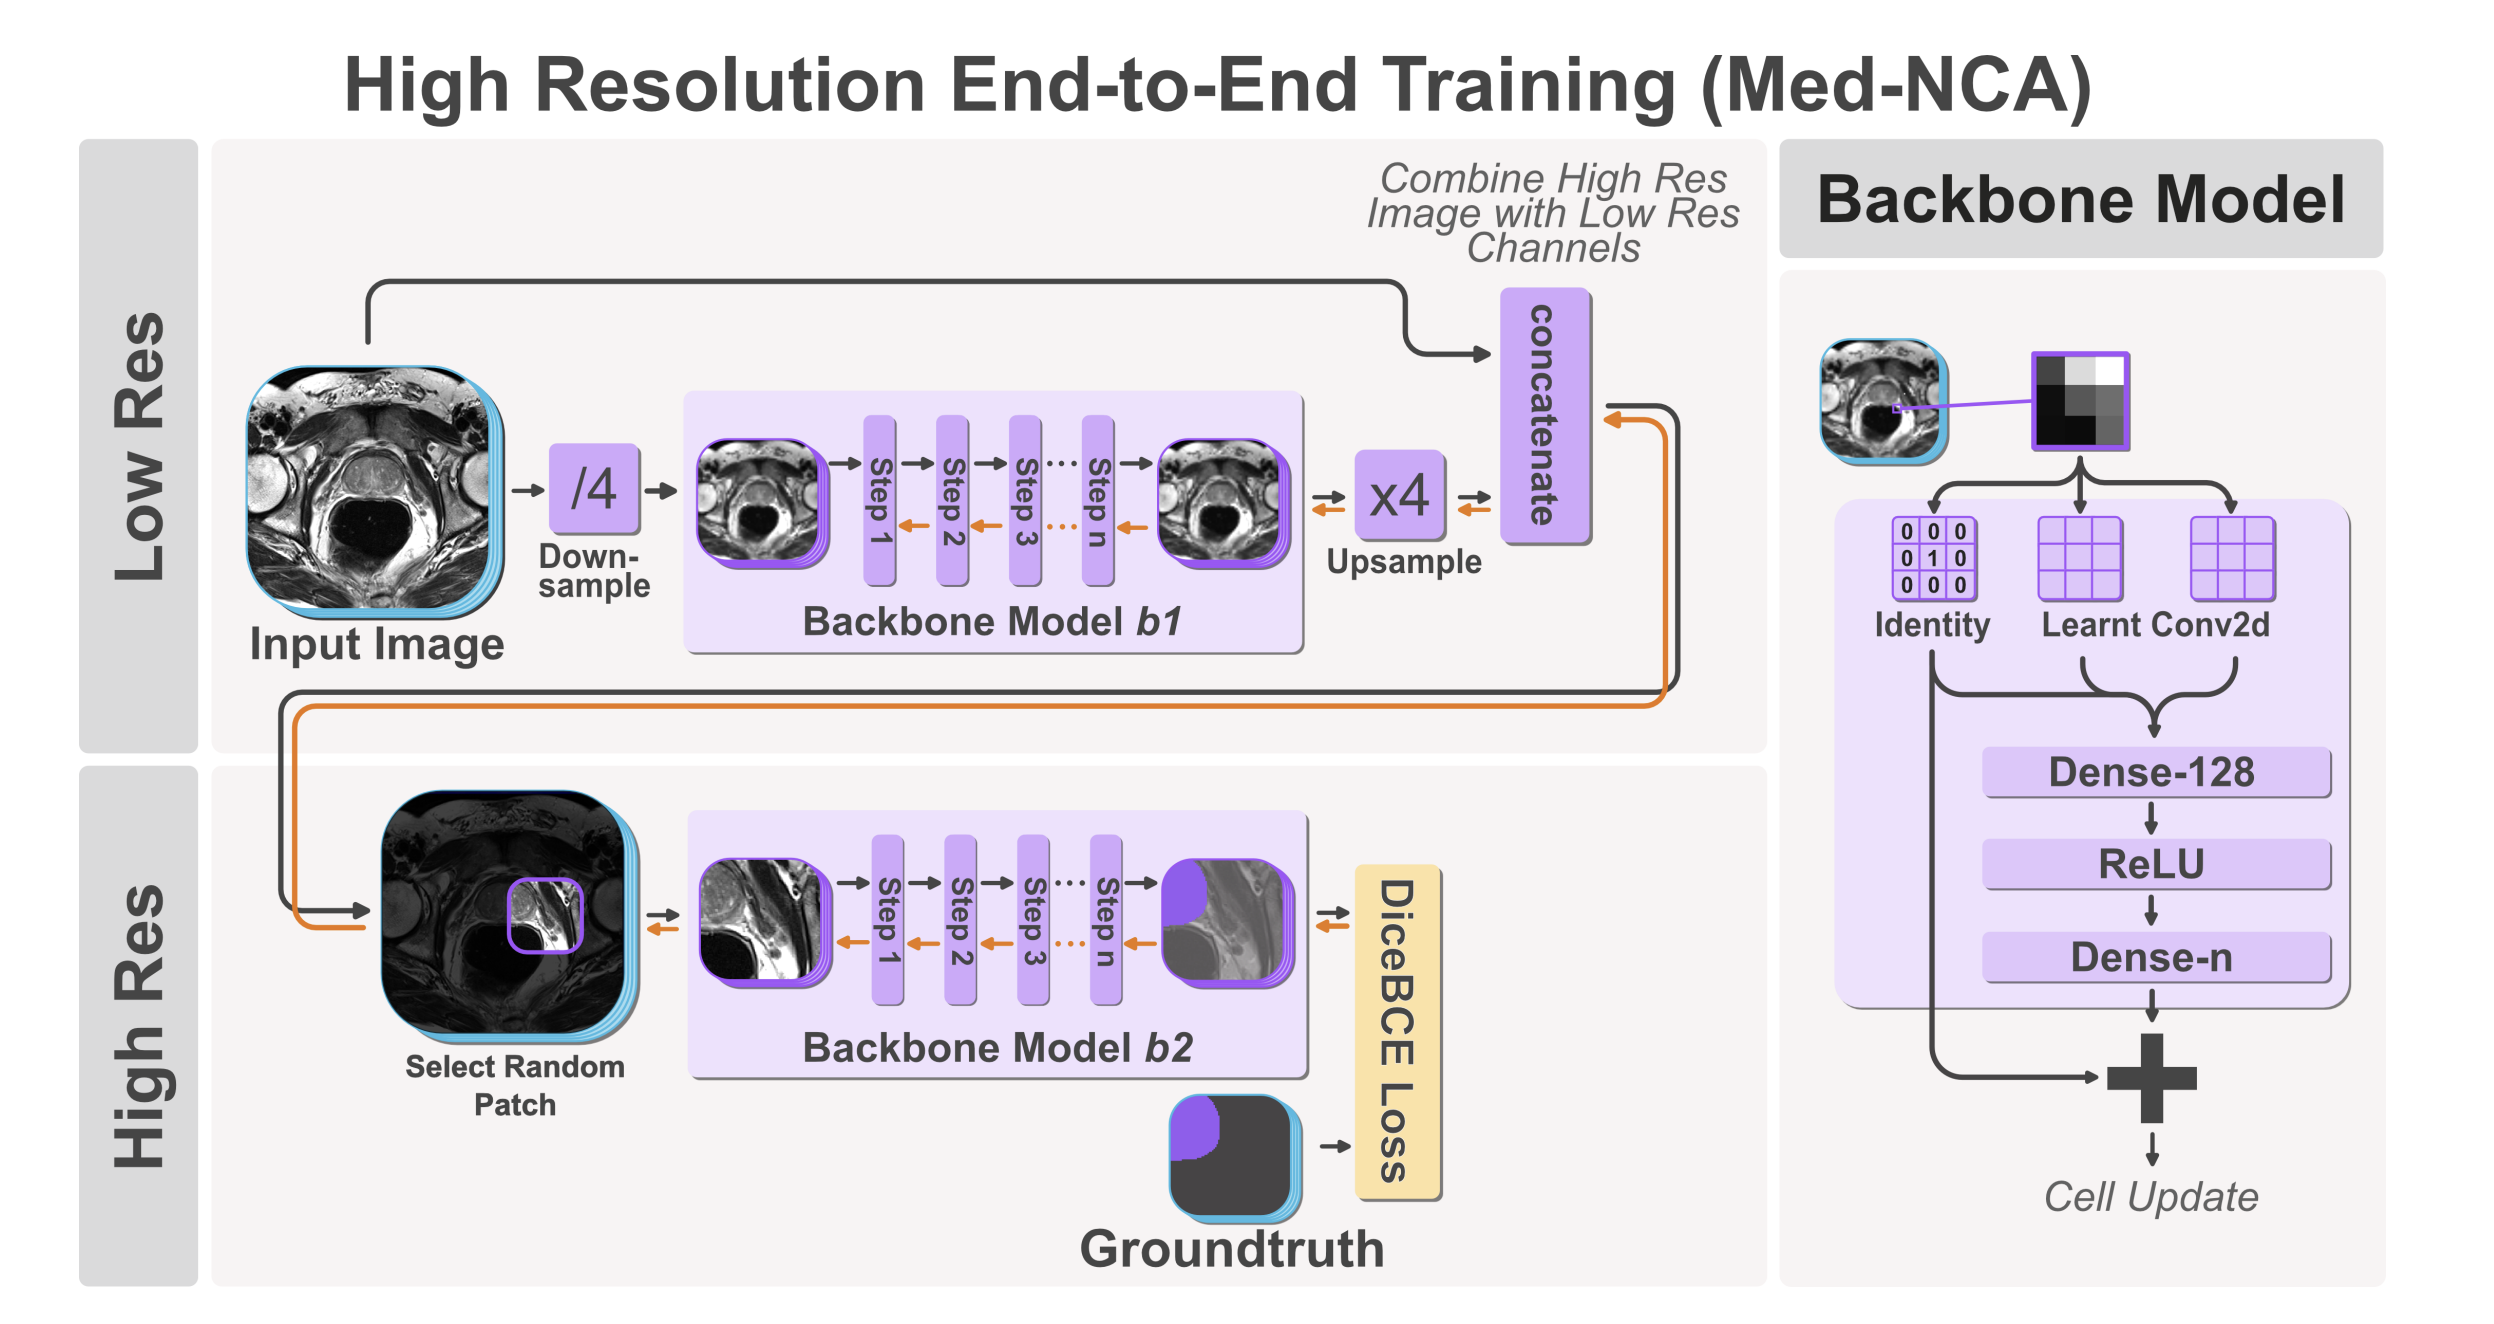

[Source](https://arxiv.org/pdf/2302.03473)

In [ ]:
def train_mednca():
    """Main training function for Med-NCA"""

    dataset = SliceDataset("INSERT/path/to/output/images", "INSERT/path/to/output/labels")
    writer = SummaryWriter(log_dir="INSERT/path/to/runs")
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Our two NCA models:
    # - model1: coarse processing
    # - model2: fine processing
    model1 = NCA2D(c=16, k=7, fire_rate=0.5).cuda()
    model2 = NCA2D(c=16, k=3, fire_rate=0.5).cuda()

    model1.train()
    model2.train()
    opt = torch.optim.Adam(list(model1.parameters()) + list(model2.parameters()), lr=1e-4)

    scheduler = StepLR(opt, step_size=50, gamma= 0.5)

    for epoch in range(150):
        epoch_loss = 0
        epoch_dice = 0
        epoch_bce = 0
        num_batches = 0

        progress_bar = tqdm(loader, desc=f'Epoch {epoch}', leave=True)

        for img, lbl in progress_bar:
            img, lbl = img.cuda(), lbl.cuda()
            lbl = lbl.float()
            #fix original image
            original_img = img.clone()

            
            _, _, H, W = img.shape
            assert H >= 4 and W >= 4, f"Too small for interpolation: H={H}, W={W}" 

            # Downsample by a factor of 4 for coarse processing
            img_down = F.interpolate(img, scale_factor=1/4, mode='bilinear')

            # Initialize state for coarse NCA
            B, C, H_down, W_down = img_down.shape
            state1 = torch.zeros(B, 16, H_down, W_down, device=img.device)
            state1[:, :C] = img_down 
           
           # Process through coarse nca
            for _ in range(40):
                state1 = model1(state1)
    

            # Upscale coarse features
            up = F.interpolate(state1[:, 1:], scale_factor=4, mode='bilinear')
            
            # Initialize state for fine NCA
            state2 = torch.zeros(B, 16, *img.shape[2:], device=img.device)
            state2[:, :C] = original_img
            state2[:, C:] = up

            # Process through fine nca
            for _ in range(20):
                state2 = model2(state2)
                

            # Output is channel 1
            pred = state2[:, 1:2]


            # Combine the losses
            dice = dice_loss(pred, lbl)
            bce = bce_loss(pred, lbl)
            loss = dice + bce


            # Optimization step
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Logging
            batch_loss = loss.item()
            batch_dice = dice.item()
            batch_bce = bce.item()

            epoch_loss += batch_loss
            epoch_dice += batch_dice
            epoch_bce += batch_bce
            num_batches += 1

            global_step = epoch * len(loader) + num_batches

            writer.add_scalar('Loss/batch', batch_loss, global_step)
            writer.add_scalar('Dice/batch', batch_dice, global_step)
            writer.add_scalar('BCE/batch', batch_bce, global_step)

            progress_bar.set_postfix({
                'loss': f'{batch_loss:.4f}',
                'dice': f'{batch_dice:.4f}',
                'bce': f'{batch_bce:.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })

        # Summarize per epoch
        avg_loss = epoch_loss / num_batches
        avg_dice = epoch_dice / num_batches
        avg_bce = epoch_bce / num_batches

        print(f"Epoch {epoch} Avg Loss {avg_loss:.4f} Avg Dice {avg_dice:.4f} Avg BCE {avg_bce:.4f}")

    
        writer.add_scalar('Loss/epoch', avg_loss, epoch)
        writer.add_scalar('Dice/epoch', avg_dice, epoch)
        writer.add_scalar('BCE/epoch', avg_bce, epoch)


        scheduler.step()

    writer.close()

    # Save models 
    SAVE = "INSERT/path/to/models"
    torch.save(model1.state_dict(), os.path.join(SAVE, "model1.pth"))
    torch.save(model2.state_dict(), os.path.join(SAVE, "model2.pth"))
    print(f"Models saved.")

    

## 5. Evaluation and Visualization
### 5.1 Visualizing Predictions:
If needed, it might be helpful to visualize the predictions.

In [ ]:
def visualize_predictions(img, label, pred, save_path, index):
    """Generates plots comparing the input, the ground truth and the prediction"""
    img = img.squeeze().cpu()
    label = label.squeeze().cpu()
    pred = torch.sigmoid(pred.squeeze()).cpu()
    pred_mask = (pred > 0.5).float()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("Input Image")
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Prediction")

    for ax in axs:
        ax.axis('off')

    os.makedirs(save_path, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"sample_{index}.png"))
    plt.close()


### 5.2 Evaluation
Now we can evaluate the model!


In [ ]:
def eval_mednca(model1, model2, dataloader, device="cuda", writer=None, epoch=None):
    """Evaluation function for Med-NCA"""
    model1.eval()
    model2.eval()
    dice_total, bce_total, score_total, count = 0.0, 0.0, 0.0, 0

    save_path = "INSERT/path/to/predictions"
    if epoch is not None:
        save_path = os.path.join(save_path, f"epoch_{epoch}")

    with torch.no_grad():
        for idx, (img, lbl) in enumerate(tqdm(dataloader, desc="Validating")):
            img, lbl = img.to(device), lbl.to(device).float()
            

            # Forward pass same as training
            original_img = img.clone()
            img_down = F.interpolate(img, scale_factor=1/4, mode='bilinear')

            B, C, H_down, W_down = img_down.shape
            state1 = torch.zeros(B, 16, H_down, W_down, device=device)
            state1[:, :C] = img_down

            for _ in range(40):
                state1 = model1(state1)

            up = F.interpolate(state1[:, 1:], scale_factor=4, mode='bilinear')

            state2 = torch.zeros(B, 16, *img.shape[2:], device=device)
            state2[:, :C] = original_img
            state2[:, C:] = up

            for _ in range(20):
                state2 = model2(state2)

            pred = state2[:, 1:2]

            # Compute necessary metrics
            dice = dice_loss(pred, lbl).item()
            bce = bce_loss(pred, lbl).item()
            score = dice_score(pred, lbl).item()

            # Save a few sample prediction visualizations
            if idx < 5:
                visualize_predictions(img[0], lbl[0], pred[0], save_path, index=idx)


            # Accumulate metrics
            dice_total += dice
            bce_total += bce
            score_total += score
            count += 1

    # Print and log results
    avg_dice = dice_total / count
    avg_bce = bce_total / count
    avg_score = score_total / count

    print(f"[Validation] Dice: {avg_dice:.4f} | BCE: {avg_bce:.4f} | DiceScore: {avg_score:.4f}")    

    if writer is not None and epoch is not None:
        writer.add_scalar("Val/DiceLoss", avg_dice, epoch)
        writer.add_scalar("Val/BCELoss", avg_bce, epoch)
        writer.add_scalar("Val/DiceScore", avg_score, epoch)